In [1]:
from scCRTUtils import *
from Estimate import Estimate_time
from run_test import *
device = torch.device('cpu')


import umap
import umap.plot

import matplotlib.pyplot as plt
import matplotlib

In [2]:
############################## 1. Given the raw count and preprocess data  ##############################
'''
actual topology of binary_tree_8
M1 --> M3
M3 --> M2
M3 --> M7
M7 --> M5
M7 --> M8
M5 --> M4
M5 --> M6
'''
set_seed(1)
args = setup_args().parse_known_args()[0]
# from .rds, need R environment
# dataset_path = 'src/scCRT/data/binary_tree_8.rds'
# dataset_label_path = None

# from .csv
dataset_path = 'data/binary_tree_8.csv'
dataset_label_path = 'data/binary_tree_8_label.csv'


## get and preprocess data
# get_data
data_counts, cell_labels, cells, name2ids, ids2name, cell_times, pre_infos = getInputData(dataset_path, 
                                                                                          dataset_label_path)

# preprocess
if cell_labels is None:
    features, cell_labels = pre_process(data_counts, WithoutLabel=True)
else:
    features = pre_process(data_counts)

/Users/seutatsu/PycharmProjects/scCRT/upLoad/scCRTUtils.py:356: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(data_counts)


In [3]:
############################## 2. learn cell features  ##############################
'''
Parameters
----------
input: 
features: the preprocessed expression matrix, [n_cell, n_genes], numpy.array
cell_labels: the label of cells, numpy.array

output: 
y_features: the learned cell features, [n_cell, feature_size]
'''

args.model_path = 'data/binary_tree_8_model.pkl'
# model_path = None
y_features = trainingModel(features, cell_labels, args)

In [4]:
############################## 3. get trajectory ##############################
# given the start node
if pre_infos is not None:
    start_node = name2ids[str(pandas2ri.rpy2py(pre_infos[2])[0])]
else:
    start_node=0

# get the clusters
trajectory_data = get_trajectory(cell_labels, 
            y_features, ids2name, cells, start_node=start_node, norm=False, k=10)

network = trajectory_data[0].values.T[:2]
for [s,t] in zip(network[0], network[1]):
    print(f'{s} --> {t}')

M1 --> M3
M3 --> M2
M3 --> M7
M7 --> M5
M5 --> M4
M5 --> M6
M7 --> M8


In [6]:
############################## 3.1 evaluation the trajectory ##############################
# calculate HIM, F1-branches, F1-milestones using dyneval (need to install dyneval of R version)
if '.rds' in dataset_path:
    HIM, F1_branches, F1_milestones = evaluation(pre_infos, evaluation_details)
    print('HIM:{:.3f}, F1-branches:{:.3f}, F1-milestones:{:.3f}'.format(HIM, F1_branches, F1_milestones))

HIM:1.000, F1-branches:0.566, F1-milestones:0.760


In [5]:
############################## 4. estimate pseudotimes ##############################
time_model = Estimate_time(y_features, cell_labels, start_node=start_node, 
                          k=20)
time_model.fit(num_epochs=1)

predict_times = time_model.unified_pseudotime.astype(float)

In [6]:
# (1) the PCCs of all cells
total_time = np.corrcoef(predict_times, cell_times.astype(float))[1,0]

# (2) the average PCCs of each lineage
avg_times = []
for one_line, curve in zip(time_model.Lineage_class.lineages, time_model.curves):
    cell_mask = np.logical_or.reduce(np.array([cell_labels == k for k in one_line.lineage]))
    pseudotime = curve.pseudotimes_interp[cell_mask] # 预测顺序
    select_cells_times = cell_times[cell_mask]
    avg_times.append(np.corrcoef(pseudotime.astype(float), select_cells_times.astype(float))[1,0])

avg_time = np.mean(np.array(avg_times))

In [7]:
avg_time

0.9553730840199809

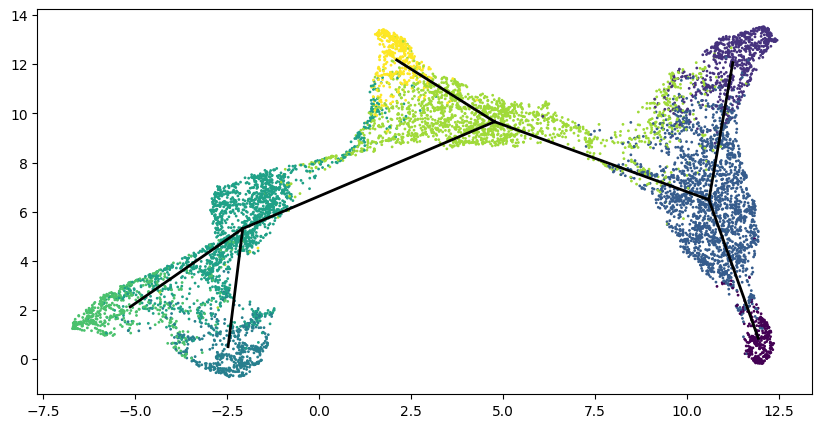

In [14]:
############################## 5. Visualized minimum spanning tree ##############################

X_tsne = umap.UMAP().fit_transform(y_features)


plt.figure(figsize=(10, 5))

scatter=plt.scatter(X_tsne[:, 0], X_tsne[:, 1],  c=cell_labels[:], s=1)


centers4plot = []
for label_id in np.sort(list(set(cell_labels))):
    centers4plot.append(np.mean(X_tsne[cell_labels == label_id], axis=0))
centers4plot = np.array(centers4plot)
for i, j in trajectory.all_lineage_seq:
    plt.plot([centers4plot[i][0],centers4plot[j][0]] , 
                 [centers4plot[i][1],centers4plot[j][1]], 
                 color='black', zorder=10,lw=2)
plt.show()